In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib as mpl
from sklearn.linear_model import Ridge
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import math

import ResidualDecomposition as RD

np.random.seed(0)

In [2]:
data = pd.read_csv("Datasets/P_BostonHousing.csv") 
X = data.iloc[:,:-1].values
Y = data.iloc[:,-1].values
k = X.shape[1]
N = X.shape[0]

lr = Ridge()
lr.fit(X, Y)
res = lr.predict(X) - Y

In [3]:
t1_mc = time.time()

mcrshap = RD.ResidualDecompositionSymmetricStopping()
mcrshap.fit(X, Y, lr)

t2_mc = time.time()
tmc = t2_mc - t1_mc

In [4]:
print("Runtime is {}s".format(t2_mc - t1_mc))

Runtime is 692.8730387687683s


In [18]:
t1 = time.time()

iRSHAP = RD.ResidualDecompositionSymmetricInfluenceFunctionLinear(X, Y, lr)
iRSHAP.All_S_Influence(15000)
rshap1 = iRSHAP.residuals_matrix.T

t2 = time.time()
T2 = t2-t1
print("Runtime is {}s".format(t2-t1))

Runtime is 56.21780014038086s


In [6]:
t1 = time.time()

iRSHAP = RD.ResidualDecompositionSymmetricInfluenceFunctionLinear(X, Y, lr)
iRSHAP.Largest_S_Influence(100)
rshap2 = iRSHAP.residuals_matrix.T

t2 = time.time()
T3 = t2-t1
print("Runtime is {}s".format(t2-t1))

Runtime is 0.4223520755767822s


In [7]:
lr.fit(X, Y)
res = lr.predict(X) - Y

rpred = np.sum(rshap1, axis=0)
r_contribution1 = ((rshap1.T * -np.sign(res))).T

rpred = np.sum(rshap2, axis=0)
r_contribution2 = ((rshap2.T * -np.sign(res))).T

rpredS = np.sum(mcrshap.phi, axis=0)
r_contributionS = ((mcrshap.phi.T * -np.sign(res))).T

lr.fit(X, Y)
res = lr.predict(X) - Y

In [8]:
import math

In [19]:
t1 = time.time()
rkshap = RD.residual_shap_WLSN(X, Y, lr, D=5000)
t2 = time.time()

T4 = t2-t1
print("Runtime is {}s".format(t2-t1))

Runtime is 3.7921621799468994s


In [26]:
rkcontribution = rkshap.Svals.T * -np.sum(rkshap.Svals, axis=0).T

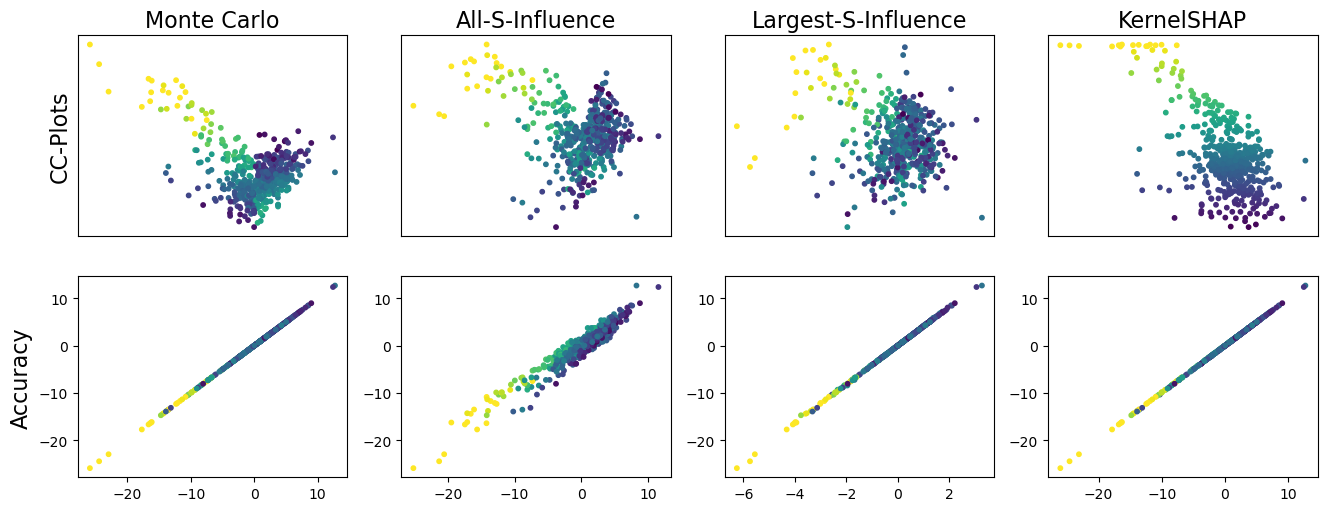

In [29]:
# Implementation bug, have to multiply some of these by -1
plt.figure(figsize=(16,12))

plt.subplot(441)
plt.title("Monte Carlo", fontsize=16)
plt.ylabel("CC-Plots", fontsize=16)
plt.scatter(np.mean(mcrshap.phi, axis=0), np.mean(r_contributionS, axis=1), c=Y, s=10)
plt.xticks([])
plt.yticks([])

plt.subplot(442)
plt.title("All-S-Influence", fontsize=16)
plt.scatter(np.mean(rshap1, axis=0), np.mean(r_contribution1, axis=1) * -1, c=Y, s=10)
plt.xticks([])
plt.yticks([])

plt.subplot(443)
plt.title("Largest-S-Influence", fontsize=16)
plt.scatter(np.mean(rshap2, axis=0), np.mean(r_contribution2, axis=1) * -1, c=Y, s=10)
plt.xticks([])
plt.yticks([])

plt.subplot(444)
plt.title("KernelSHAP", fontsize=16)
plt.scatter(np.mean(rkshap.Svals, axis=0), np.mean(rkcontribution, axis=1) * -1, c=Y, s=10)
plt.xticks([])
plt.yticks([])

plt.subplot(445)
plt.ylabel("Accuracy", fontsize=16)
plt.scatter(np.sum(mcrshap.phi, axis=0), res, c=Y, s=10)

plt.subplot(446)
plt.scatter(np.sum(rshap1, axis=0), res, c=Y, s=10)

plt.subplot(447)
plt.scatter(np.sum(rshap2, axis=0), res, c=Y, s=10)

plt.subplot(448)
plt.scatter(np.sum(rkshap.Svals, axis=0), res, c=Y, s=10)

plt.savefig("Figures/Boston_methodcomp.pdf", bbox_inches='tight')

In [12]:
IRSHAP = RD.ResidualDecompositionSymmetricInfluenceFunctionLinear(X, Y, lr)
offsetv = IRSHAP.step(np.arange(0, X.shape[0]))
lr.fit(X, Y)
res = lr.predict(X) - Y

lr.fit(X[1:,:], Y[1:])
p1 = lr.predict(X) - Y

pdiff = res - p1

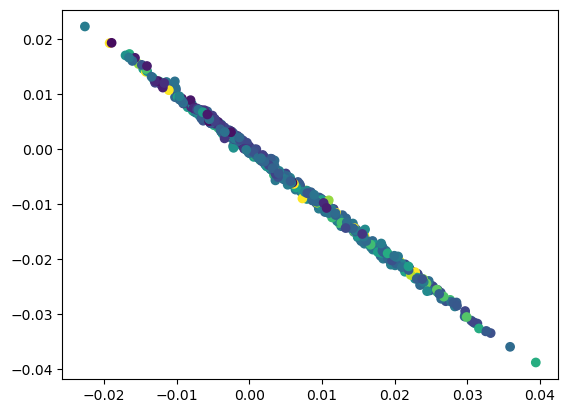

In [13]:
# Verify Influence calculation works for subset(X) = X

vset = np.arange(0, X.shape[0])
offsetv = iRSHAP.step(vset)
Xs = X[vset,:]
Ys = Y[vset]

lr.fit(X, Y)
res = lr.predict(X) - Y

lr.fit(X[1:,:], Y[1:])
p1 = lr.predict(X) - Y

pdiff = res - p1

pred_list = []
lr = Ridge()
lr.fit(X, Y)
res = lr.predict(X) - Y

for i in range(0, Xs.shape[0]):
    Xtemp = np.delete(X, i, axis=0)
    Ytemp = np.delete(Y, i, axis=0)
    
    lr.fit(Xtemp, Ytemp)
    pred_list.append(res - (lr.predict(X) - Y))
    
pred_list = np.array(pred_list)

plt.scatter(offsetv[0], pred_list[0], c=Y)

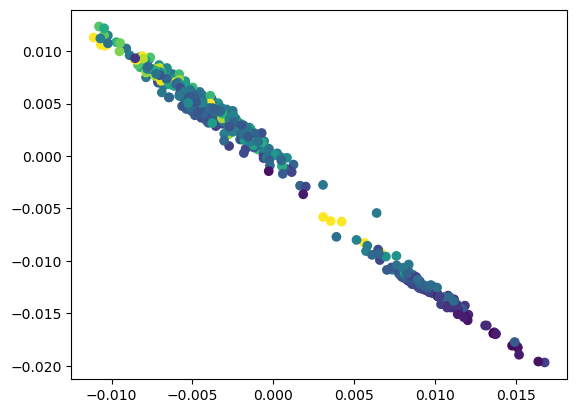

In [14]:
# Verify Influence calculation works for subset(X) = X[:40]

vset = np.arange(0, 40)
offsetv = iRSHAP.step(vset)
Xs = X[vset,:]
Ys = Y[vset]

lr.fit(Xs, Ys)
res = lr.predict(X) - Y

lr.fit(Xs[1:,:], Ys[1:])
p1 = lr.predict(X) - Y

pdiff = res - p1

pred_list = []
lr = Ridge()
lr.fit(X, Y)
res = lr.predict(X) - Y

for i in range(0, Xs.shape[0]):
    Xtemp = np.delete(X, i, axis=0)
    Ytemp = np.delete(Y, i, axis=0)
    
    lr.fit(Xtemp, Ytemp)
    pred_list.append(res - (lr.predict(X) - Y))
    
pred_list = np.array(pred_list)

plt.scatter(offsetv[0], pdiff, c=Y)